# Kinetic proofreading in templated replication; in-silico evolution

We implement our in-silico evolution work using random networks with a family of proofreading models as detailed in the Material and Methods.

#### Import modules

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import palettable as pal
import itertools
import random

import copy
from tqdm.notebook import trange, tqdm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import ScalarFormatter
from scipy import linalg as LA

import seaborn as sns
%matplotlib inline
sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":20})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

Import functions from these scripts needed to define the random network, its evolution and plot the relevant observables.

In [8]:
from physics import *
from network import *
from tools import save_vars
from evolution import *

## Random copier network

Parameters chosen for different sizes

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|7| $10^{-2}$| $10^3$| 0.4| 7| 0.2|
|3| $10^{-3}$| $10^3$| 0.4| 5| 0.5|


The following code is defined for $N=7$; parameters can be changed for $N=3$ simulations.

### Initialise parameters

In [9]:
N = 7 #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 7
dsize = 0.2
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-7.00000000e+00 -6.80000000e+00 -6.60000000e+00 -6.40000000e+00
 -6.20000000e+00 -6.00000000e+00 -5.80000000e+00 -5.60000000e+00
 -5.40000000e+00 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00
 -4.60000000e+00 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00
 -3.80000000e+00 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00
 -3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  6.21724894e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00  3.00000000e+00  3.20000000e+00
  3.40000000e+00  3.60000000e+00  3.80000000e+00  4.00000000e+00
  4.20000000e+00  4.40000000e+00  4.60000000e+00  4.80000000e+00] Length: 60
Error

#### Example for a maximal proofreading network for a given N

This is just testing that the functions defined make sense, partiularly the error one. The rates are defined ad hoc for a network that is poised at maximal discrimination.

In [10]:
kr_pr = np.zeros([N,N])
for i in range(N-1):
    kr_pr[i+1,i] = 0.8
    kr_pr[i,i+1] = 1e-2
    
kw_pr = copy.copy(kr_pr)
#kw_pr[1,2] = np.exp(delta)*kw_pr[1,2]
for i in range(N-1):
    kw_pr[i,i+1] = np.exp(delta)*kw_pr[i,i+1]
    
kr_pr = normalise_outflow(kr_pr, N)
kw_pr = normalise_outflow(kw_pr, N)

# Definition of the initial state
init = 0
p_0 = np.zeros((N,1))
p_0[init] = 1

# Definition of the final state
end = N-1
print('First passage time:', firstpt(kr_pr, p_0, N, end)[0], 'First passage time kinetic stalled:', firstpt(1e3*kr_pr, p_0, N, end)[0])

print('Maximal proofreading:', error(kr_pr, kw_pr, N, init, end),  'e^{-\Delta}:', np.exp(-(N-1)*delta))

First passage time: 7.578913635635373 First passage time kinetic stalled: 0.007578913635635366
Maximal proofreading: 0.09071766053673494 e^{-\Delta}: 0.09071795328941247


### Evolving the network

In [ ]:
q = 0 # Cost to dissipation is set to zero
n_samples = 10
mcsteps = 10000
T = 1e-2 # Evolution temperature

    
t_st = [1e3] # Stalling time

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print('Stalling time: ', t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

Quickly plotting the result of the evolution to check the outcome

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True)
for idx in range(n_samples):
    if idx == 7:
        axs[0,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_fpt_s[idx])), 'ko')
        axs[0,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_error_s[idx])), 'ko')
        
        axs[1,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_ent_s[idx])), 'ko')
        axs[1,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_speed_s[idx])), 'ko')
    else:
        axs[0,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_fpt_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        axs[0,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_error_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        
        axs[1,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_ent_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        axs[1,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_speed_s[idx])), '-', color='grey', markersize=3, alpha=0.2)

xlim = axs[0,1].get_xlim()
axs[0,1].plot(xlim, [np.exp(-delta), np.exp(-delta)], '--', color = 'black', linewidth=3, alpha=0.6, label=r'$e^{-\Delta}$')
axs[0,1].plot(xlim, [np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ':', color=(0.85, 0.37, 0.01), linewidth=3, \
              alpha=0.6, label=r'$e^{-2\Delta}$')
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1e-10,1e1])
axs[1,1].set_yscale('log')
axs[0,0].set_xscale('log')

Load the trajectories used to make the plot in Fig. 1 have been evolved with the code above and saved in a .pkl file for future use.

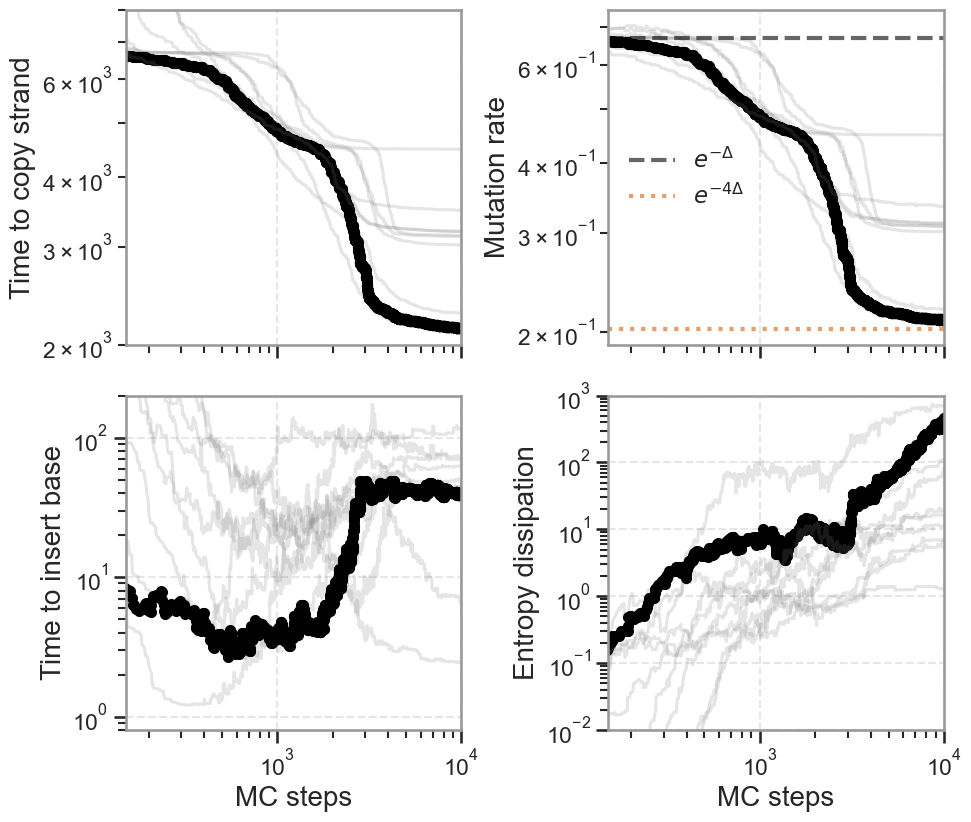

In [14]:
import pickle
with open('kinetic-proofreading_data/N_7_10_trajs.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

track_time_s =  trajs[0]
track_error_s = trajs[2]
track_fpt_s = trajs[4]
track_ent_s = trajs[3]
track_speed_s = trajs[1]
t_stall = 1e3
T = 1e-2
n_samples = 10

%autoreload
from plot import plot_observables
idx_s = 8
plot_observables(idx_s, delta, track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, N, \
                 t_stall, T, n_samples)

Code below is to save trajectories, if need so

In [120]:
# if (n_samples == 50)*(N == 3):
#     import pickle
#     trajs = [track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, track_k_s]
#     with open('N_3_50_trajs.pickle', 'wb') as handle:
#         pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# if (n_samples == 50)*(N == 5):
#     import pickle
#     trajs = [track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, track_k_s]
#     with open('N_5_50_trajs.pickle', 'wb') as handle:
#         pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Mutagenesis from an evolved network, WT equivalent

Evolve a network for speed, take the evolved solution as initial condition for mutagenesis. Mutant networks are defined by perturbing the kinetic parameters of the evolved networks: pick at random a kinetic rate and extract a new value from a Gaussian distribution centered around the original value. Different strength of mutagenesis are considered, corresponding to different values of the variance of the distribution.

In [15]:
N = 7 #  Size of the network
delta = 2.5   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 5
dsize = 0.5
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5] Length: 20
Error at initialisation: 0.08208499862386016 e^{-\Delta}: 0.0820849986238988
Sum over rows: [-1.69406589e-20  8.13151629e-20  8.94466792e-19 -1.82145965e-17
  3.38813179e-20  2.23616698e-19 -6.66133815e-16]


In [ ]:
q = 0
n_samples = 5
mcsteps = 500000
T = 1e-3 # Evolution temperature

t_st = [1e3]

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print(t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

1000.0


In [ ]:
ic = [ track_k_s[7][-1] ]
print(track_fpt_s[1][-1], track_error_s[1][-1], np.exp(-(N-int(N/2))*delta),  np.exp(-(N-int(N/2))*delta)/track_error_s[1][-1]*100)

Run the mutagenesis

In [ ]:
combs = int(1e6)
npt = 1
vec_pct = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
#params_ic = ic[1]

K_tmp_r = np.zeros([N,N])

err_loc_v, fpt_loc_v, speed_loc_v = [[] for i in range(3)]
for s in range(len(ic)):
    params_ic = ic[s]
    for pct in vec_pct:
        err_loc, fpt_loc, speed_loc = [[] for i in range(3)]
        for c in range(combs):

            K_r, _ = build_matrix_params(params_ic[0], params_ic[1], params_ic[2], N, eps_v, eps_b)
            for i in range(N):
                for j in range(N):
                    if i !=j:
                        K_tmp_r[i,j] = abs(np.random.normal(K_r[i,j], pct*K_r[i,j], npt))

            K_tmp_r = normalise_outflow(K_tmp_r, N)
            K_tmp_r1 = copy.copy(K_tmp_r)/max_k(copy.copy(K_tmp_r))

            K_tmp_w = copy.copy(K_tmp_r)    
            for i in range(N):
                for j in range(N):
                    if i < int(N/2) and j >= int(N/2):
                        K_tmp_w[i,j] = K_tmp_w[i,j]*np.exp(delta)


            K_tmp_w = normalise_outflow(K_tmp_w, N)
            K_tmp_w1 = copy.copy(K_tmp_w)/max_k(copy.copy(K_tmp_r))

            fpt = firstpt(copy.copy(K_tmp_r1), p_0, N, end)
            err = error(K_tmp_r1, K_tmp_w1, N, init, end)
            err_loc.append( err )
            fpt_loc.append( fpt )
            speed_loc.append( fpt + t_stall*err )
        err_loc_v.append(err_loc)
        fpt_loc_v.append(fpt_loc)
        speed_loc_v.append(speed_loc)

Plot the result of the mutagenesis

In [ ]:
fig_width_inches = 2  # Width in inches - as requested
# Calculate height to maintain original proportions
original_ratio = 4.6/4.2
fig_height_inches = fig_width_inches / original_ratio  # = 3/1.625 = 1.85 inches

fig, axs = plt.subplots(1, 1, figsize=(fig_width_inches, fig_height_inches), sharex=True)
for i in reversed(range(len(vec_pct))):
        axs.plot(err_loc_v[i], speed_loc_v[i], 'o', \
                 color=pal.scientific.sequential.GrayC_12.mpl_colors[i], markersize=3, rasterized=True)

ylim = axs.get_ylim()
axs.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, alpha=0.6, label=r'$e^{-\Delta}$')
axs.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color=(0.85, 0.37, 0.01), linewidth=3, \
              alpha=0.6, label=r'$e^{-2\Delta}$')

K_r, _ = build_matrix_params(params_ic[0], params_ic[1], params_ic[2], N, eps_v, eps_b)
K_r = normalise_outflow(K_r, N)
K_w = copy.copy(K_r)    
for i in range(N):
    for j in range(N):
        if i < int(N/2) and j >= int(N/2):
            K_w[i,j] = K_w[i,j]*np.exp(delta)


K_w = normalise_outflow(K_w, N)
K_w = copy.copy(K_w)/max_k(copy.copy(K_r))

fpt = firstpt(copy.copy(K_r), p_0, N, end)
err = error(K_r, K_w, N, init, end)

axs.plot(err, fpt + t_stall*err, '*', \
                 color='red', markersize=10, rasterized=True)

# Set title and labels with customized font sizes
#ax.set_title(title, fontsize=10, pad=15, color='black', fontweight='normal')
axs.set_xlabel('', fontsize=9)  # X-axis label size
axs.set_ylabel('', fontsize=9, color='0.15')  # Y-axis label size 85% black

# Format axes - set tick label size and ensure ticks are visible
axs.tick_params(axis='both', labelsize=7, colors='0.15')
#axs.tick_params(axis='both', which='major', labelsize=7, colors='0.15', 
              #bottom=True, left=True, width=0.8, length=3.0)

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Error rate')
axs.set_ylabel('Time to replicate')
axs.set_ylim([0.5,1*10**3])
#plt.savefig('theorytradeoff.pdf', dpi=300, bbox_inches='tight', facecolor='#fcfcfc')

## Looking for the trade-off

Random sampling for a network of size $N=3$. See later for loading the saved random sampling scatter plot. The following simulation takes time.

In [50]:
N = 3         #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 7
dsize = 0.2
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

q = 0

print('Maximal discrimination: ', N-int(N/2))

Genome: [-7.00000000e+00 -6.80000000e+00 -6.60000000e+00 -6.40000000e+00
 -6.20000000e+00 -6.00000000e+00 -5.80000000e+00 -5.60000000e+00
 -5.40000000e+00 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00
 -4.60000000e+00 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00
 -3.80000000e+00 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00
 -3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  6.21724894e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00  3.00000000e+00  3.20000000e+00
  3.40000000e+00  3.60000000e+00  3.80000000e+00  4.00000000e+00
  4.20000000e+00  4.40000000e+00  4.60000000e+00  4.80000000e+00] Length: 60
Error

In [532]:
track_errorsp, track_fptsp = [ [] for i in range(2)]

n_scatter = int(1e6)
for i in tqdm(range(n_scatter)):
    
    k_r, k_w, V_r, B_r, mu_r = initialise_k_mu(V, B, mu, N, eps_v, eps_b)
        
    f = error(k_r, k_w, N, init, end).item()
    g = firstpt(copy.copy(k_r), p_0, N, end).item()
    if (f <= np.exp(-delta))*(g < 1e3):
        track_errorsp.append(f)
        track_fptsp.append(g)





  0%|          | 0/1000000 [00:00<?, ?it/s]



  0%|          | 100/1000000 [00:00<16:42, 997.72it/s]



  0%|          | 205/1000000 [00:00<16:27, 1012.77it/s]



  0%|          | 359/1000000 [00:00<14:45, 1128.41it/s]



  0%|          | 519/1000000 [00:00<13:27, 1237.21it/s]



  0%|          | 676/1000000 [00:00<12:37, 1319.37it/s]



  0%|          | 797/1000000 [00:00<14:35, 1140.75it/s]



  0%|          | 933/1000000 [00:00<13:53, 1197.96it/s]



  0%|          | 1093/1000000 [00:00<12:51, 1294.39it/s]



  0%|          | 1284/1000000 [00:00<11:37, 1432.66it/s]



  0%|          | 1484/1000000 [00:01<10:37, 1565.91it/s]



  0%|          | 1649/1000000 [00:01<10:35, 1571.86it/s]



  0%|          | 1812/1000000 [00:01<10:31, 1581.81it/s]



  0%|          | 1974/1000000 [00:01<10:36, 1567.61it/s]



  0%|          | 2134/1000000 [00:01<10:33, 1575.66it/s]



  0%|          | 2335/1000000 [00:01<09:52, 1682.98it/s]



  0%|          | 2507/1000000 [00:01<12:52, 1291.82it/s]


  4%|▎         | 36002/1000000 [00:25<11:38, 1379.28it/s]



  4%|▎         | 36141/1000000 [00:26<11:44, 1368.62it/s]



  4%|▎         | 36282/1000000 [00:26<11:38, 1380.35it/s]



  4%|▎         | 36429/1000000 [00:26<11:25, 1405.65it/s]



  4%|▎         | 36579/1000000 [00:26<11:13, 1430.95it/s]



  4%|▎         | 36738/1000000 [00:26<10:53, 1473.93it/s]



  4%|▎         | 36900/1000000 [00:26<10:35, 1514.88it/s]



  4%|▎         | 37053/1000000 [00:26<10:37, 1510.25it/s]



  4%|▎         | 37205/1000000 [00:26<10:49, 1483.50it/s]



  4%|▎         | 37366/1000000 [00:26<10:33, 1519.25it/s]



  4%|▍         | 37519/1000000 [00:26<10:56, 1465.35it/s]



  4%|▍         | 37667/1000000 [00:27<11:12, 1430.66it/s]



  4%|▍         | 37831/1000000 [00:27<10:47, 1486.74it/s]



  4%|▍         | 37982/1000000 [00:27<10:44, 1492.69it/s]



  4%|▍         | 38133/1000000 [00:27<10:51, 1476.84it/s]



  4%|▍         | 38282/1000000 [00:27<11:01, 1454.16it/s]



  4%|▍         | 38428/1

  8%|▊         | 81188/1000000 [00:49<09:01, 1697.10it/s]



  8%|▊         | 81367/1000000 [00:49<08:52, 1723.56it/s]



  8%|▊         | 81546/1000000 [00:49<10:00, 1528.54it/s]



  8%|▊         | 81720/1000000 [00:49<09:38, 1586.33it/s]



  8%|▊         | 81932/1000000 [00:49<08:57, 1708.55it/s]



  8%|▊         | 82111/1000000 [00:49<09:26, 1620.41it/s]



  8%|▊         | 82286/1000000 [00:49<09:14, 1654.90it/s]



  8%|▊         | 82456/1000000 [00:49<09:40, 1581.08it/s]



  8%|▊         | 82618/1000000 [00:49<10:24, 1469.41it/s]



  8%|▊         | 82770/1000000 [00:50<10:32, 1450.76it/s]



  8%|▊         | 82978/1000000 [00:50<09:35, 1594.80it/s]



  8%|▊         | 83194/1000000 [00:50<08:50, 1729.23it/s]



  8%|▊         | 83391/1000000 [00:50<08:30, 1794.74it/s]



  8%|▊         | 83604/1000000 [00:50<08:06, 1882.99it/s]



  8%|▊         | 83819/1000000 [00:50<07:48, 1954.33it/s]



  8%|▊         | 84041/1000000 [00:50<07:32, 2026.17it/s]



  8%|▊         | 84259/1

 10%|█         | 103979/1000000 [01:00<07:31, 1985.05it/s]



 10%|█         | 104186/1000000 [01:00<07:25, 2009.41it/s]



 10%|█         | 104388/1000000 [01:00<07:29, 1991.06it/s]



 10%|█         | 104607/1000000 [01:01<07:17, 2044.65it/s]



 10%|█         | 104829/1000000 [01:01<07:07, 2094.26it/s]



 11%|█         | 105040/1000000 [01:01<07:07, 2091.81it/s]



 11%|█         | 105261/1000000 [01:01<07:00, 2125.74it/s]



 11%|█         | 105476/1000000 [01:01<06:59, 2131.25it/s]



 11%|█         | 105690/1000000 [01:01<07:07, 2090.32it/s]



 11%|█         | 105900/1000000 [01:01<07:19, 2032.60it/s]



 11%|█         | 106104/1000000 [01:01<07:33, 1973.14it/s]



 11%|█         | 106303/1000000 [01:01<07:35, 1960.97it/s]



 11%|█         | 106512/1000000 [01:01<07:27, 1996.10it/s]



 11%|█         | 106713/1000000 [01:02<07:34, 1965.44it/s]



 11%|█         | 106918/1000000 [01:02<07:28, 1989.85it/s]



 11%|█         | 107124/1000000 [01:02<07:24, 2008.98it/s]



 11%|█  

 15%|█▍        | 149515/1000000 [01:23<07:33, 1877.31it/s]



 15%|█▍        | 149704/1000000 [01:23<07:38, 1853.82it/s]



 15%|█▍        | 149913/1000000 [01:23<07:23, 1917.96it/s]



 15%|█▌        | 150117/1000000 [01:23<07:15, 1951.41it/s]



 15%|█▌        | 150313/1000000 [01:23<07:33, 1872.50it/s]



 15%|█▌        | 150513/1000000 [01:23<07:25, 1907.78it/s]



 15%|█▌        | 150706/1000000 [01:24<07:24, 1912.29it/s]



 15%|█▌        | 150914/1000000 [01:24<07:13, 1958.78it/s]



 15%|█▌        | 151111/1000000 [01:24<07:16, 1944.21it/s]



 15%|█▌        | 151306/1000000 [01:24<07:20, 1925.87it/s]



 15%|█▌        | 151500/1000000 [01:24<07:25, 1902.98it/s]



 15%|█▌        | 151691/1000000 [01:24<07:33, 1870.47it/s]



 15%|█▌        | 151901/1000000 [01:24<07:18, 1932.07it/s]



 15%|█▌        | 152103/1000000 [01:24<07:13, 1955.58it/s]



 15%|█▌        | 152311/1000000 [01:24<07:05, 1990.77it/s]



 15%|█▌        | 152511/1000000 [01:24<07:06, 1988.60it/s]



 15%|█▌ 

 19%|█▉        | 191367/1000000 [01:46<07:46, 1733.18it/s]



 19%|█▉        | 191544/1000000 [01:46<08:06, 1661.77it/s]



 19%|█▉        | 191714/1000000 [01:46<08:15, 1630.04it/s]



 19%|█▉        | 191889/1000000 [01:46<08:05, 1663.16it/s]



 19%|█▉        | 192058/1000000 [01:46<08:48, 1529.26it/s]



 19%|█▉        | 192215/1000000 [01:47<15:05, 892.34it/s] 



 19%|█▉        | 192378/1000000 [01:47<13:02, 1031.84it/s]



 19%|█▉        | 192574/1000000 [01:47<11:11, 1202.37it/s]



 19%|█▉        | 192762/1000000 [01:47<09:59, 1347.08it/s]



 19%|█▉        | 192926/1000000 [01:47<16:47, 800.84it/s] 



 19%|█▉        | 193060/1000000 [01:48<14:46, 910.65it/s]



 19%|█▉        | 193253/1000000 [01:48<12:25, 1081.53it/s]



 19%|█▉        | 193443/1000000 [01:48<10:49, 1241.65it/s]



 19%|█▉        | 193645/1000000 [01:48<09:34, 1402.90it/s]



 19%|█▉        | 193818/1000000 [01:48<11:28, 1170.93it/s]



 19%|█▉        | 193965/1000000 [01:48<15:20, 875.92it/s] 



 19%|█▉  

 23%|██▎       | 231001/1000000 [02:11<06:56, 1848.15it/s]



 23%|██▎       | 231187/1000000 [02:11<06:55, 1849.91it/s]



 23%|██▎       | 231389/1000000 [02:11<06:45, 1895.87it/s]



 23%|██▎       | 231580/1000000 [02:12<06:50, 1873.41it/s]



 23%|██▎       | 231768/1000000 [02:12<07:13, 1772.52it/s]



 23%|██▎       | 231959/1000000 [02:12<07:03, 1811.59it/s]



 23%|██▎       | 232142/1000000 [02:12<07:07, 1797.41it/s]



 23%|██▎       | 232343/1000000 [02:12<06:54, 1853.38it/s]



 23%|██▎       | 232540/1000000 [02:12<06:47, 1885.07it/s]



 23%|██▎       | 232730/1000000 [02:12<06:58, 1834.75it/s]



 23%|██▎       | 232934/1000000 [02:12<06:45, 1890.55it/s]



 23%|██▎       | 233139/1000000 [02:12<06:36, 1935.16it/s]



 23%|██▎       | 233334/1000000 [02:12<06:35, 1939.31it/s]



 23%|██▎       | 233535/1000000 [02:13<06:31, 1957.76it/s]



 23%|██▎       | 233732/1000000 [02:13<06:53, 1852.97it/s]



 23%|██▎       | 233919/1000000 [02:13<08:04, 1580.31it/s]



 23%|██▎

 27%|██▋       | 272622/1000000 [02:34<07:01, 1724.51it/s]



 27%|██▋       | 272811/1000000 [02:34<06:51, 1769.23it/s]



 27%|██▋       | 273010/1000000 [02:34<06:37, 1829.22it/s]



 27%|██▋       | 273196/1000000 [02:35<06:41, 1812.44it/s]



 27%|██▋       | 273379/1000000 [02:35<06:47, 1784.79it/s]



 27%|██▋       | 273577/1000000 [02:35<06:35, 1837.67it/s]



 27%|██▋       | 273779/1000000 [02:35<06:24, 1888.07it/s]



 27%|██▋       | 273970/1000000 [02:35<06:24, 1889.98it/s]



 27%|██▋       | 274160/1000000 [02:35<06:35, 1833.15it/s]



 27%|██▋       | 274345/1000000 [02:35<06:44, 1795.61it/s]



 27%|██▋       | 274526/1000000 [02:35<06:47, 1781.94it/s]



 27%|██▋       | 274726/1000000 [02:35<06:33, 1841.63it/s]



 27%|██▋       | 274929/1000000 [02:35<06:22, 1893.16it/s]



 28%|██▊       | 275126/1000000 [02:36<06:18, 1914.16it/s]



 28%|██▊       | 275326/1000000 [02:36<06:14, 1936.99it/s]



 28%|██▊       | 275524/1000000 [02:36<06:11, 1948.79it/s]



 28%|██▊

 31%|███▏      | 314449/1000000 [02:57<06:19, 1807.11it/s]



 31%|███▏      | 314643/1000000 [02:57<06:11, 1844.23it/s]



 31%|███▏      | 314838/1000000 [02:57<06:05, 1873.31it/s]



 32%|███▏      | 315037/1000000 [02:58<05:59, 1905.45it/s]



 32%|███▏      | 315235/1000000 [02:58<05:55, 1926.70it/s]



 32%|███▏      | 315436/1000000 [02:58<05:51, 1950.04it/s]



 32%|███▏      | 315643/1000000 [02:58<05:44, 1983.93it/s]



 32%|███▏      | 315842/1000000 [02:58<05:48, 1963.04it/s]



 32%|███▏      | 316039/1000000 [02:58<05:51, 1945.85it/s]



 32%|███▏      | 316234/1000000 [02:58<05:55, 1922.02it/s]



 32%|███▏      | 316444/1000000 [02:58<05:46, 1971.86it/s]



 32%|███▏      | 316642/1000000 [02:58<05:53, 1930.78it/s]



 32%|███▏      | 316836/1000000 [02:58<06:00, 1895.94it/s]



 32%|███▏      | 317027/1000000 [02:59<06:12, 1831.59it/s]



 32%|███▏      | 317232/1000000 [02:59<06:00, 1891.99it/s]



 32%|███▏      | 317436/1000000 [02:59<05:53, 1932.32it/s]



 32%|███

 36%|███▌      | 356857/1000000 [03:20<05:52, 1824.01it/s]



 36%|███▌      | 357042/1000000 [03:20<05:51, 1829.66it/s]



 36%|███▌      | 357226/1000000 [03:20<05:52, 1825.31it/s]



 36%|███▌      | 357422/1000000 [03:20<05:44, 1863.60it/s]



 36%|███▌      | 357620/1000000 [03:21<05:38, 1896.70it/s]



 36%|███▌      | 357826/1000000 [03:21<05:30, 1941.01it/s]



 36%|███▌      | 358025/1000000 [03:21<05:28, 1954.55it/s]



 36%|███▌      | 358231/1000000 [03:21<05:23, 1984.33it/s]



 36%|███▌      | 358430/1000000 [03:21<05:26, 1965.03it/s]



 36%|███▌      | 358627/1000000 [03:21<05:35, 1912.56it/s]



 36%|███▌      | 358819/1000000 [03:21<05:39, 1885.85it/s]



 36%|███▌      | 359014/1000000 [03:21<05:36, 1902.99it/s]



 36%|███▌      | 359205/1000000 [03:21<05:42, 1869.82it/s]



 36%|███▌      | 359393/1000000 [03:21<05:57, 1793.94it/s]



 36%|███▌      | 359588/1000000 [03:22<05:48, 1835.90it/s]



 36%|███▌      | 359787/1000000 [03:22<05:40, 1879.32it/s]



 36%|███

 40%|███▉      | 399093/1000000 [03:43<05:38, 1776.44it/s]



 40%|███▉      | 399281/1000000 [03:43<05:32, 1805.49it/s]



 40%|███▉      | 399478/1000000 [03:43<05:24, 1850.58it/s]



 40%|███▉      | 399664/1000000 [03:43<05:32, 1806.93it/s]



 40%|███▉      | 399846/1000000 [03:43<05:44, 1744.09it/s]



 40%|████      | 400022/1000000 [03:43<05:45, 1735.84it/s]



 40%|████      | 400197/1000000 [03:44<05:56, 1681.24it/s]



 40%|████      | 400388/1000000 [03:44<05:44, 1742.25it/s]



 40%|████      | 400595/1000000 [03:44<05:27, 1827.62it/s]



 40%|████      | 400780/1000000 [03:44<05:38, 1772.83it/s]



 40%|████      | 400962/1000000 [03:44<05:35, 1785.89it/s]



 40%|████      | 401142/1000000 [03:44<05:36, 1778.81it/s]



 40%|████      | 401342/1000000 [03:44<05:25, 1838.27it/s]



 40%|████      | 401549/1000000 [03:44<05:14, 1900.44it/s]



 40%|████      | 401741/1000000 [03:44<05:15, 1898.30it/s]



 40%|████      | 401940/1000000 [03:44<05:10, 1923.68it/s]



 40%|███

 43%|████▎     | 433417/1000000 [04:08<12:31, 753.86it/s]



 43%|████▎     | 433500/1000000 [04:08<12:11, 773.91it/s]



 43%|████▎     | 433580/1000000 [04:08<13:54, 678.90it/s]



 43%|████▎     | 433656/1000000 [04:09<13:27, 701.15it/s]



 43%|████▎     | 433780/1000000 [04:09<11:46, 801.14it/s]



 43%|████▎     | 433867/1000000 [04:09<13:55, 677.83it/s]



 43%|████▎     | 433943/1000000 [04:09<14:06, 668.90it/s]



 43%|████▎     | 434016/1000000 [04:09<16:14, 580.66it/s]



 43%|████▎     | 434081/1000000 [04:09<18:25, 511.75it/s]



 43%|████▎     | 434171/1000000 [04:09<16:03, 587.24it/s]



 43%|████▎     | 434306/1000000 [04:10<13:20, 706.73it/s]



 43%|████▎     | 434424/1000000 [04:10<11:44, 803.20it/s]



 43%|████▎     | 434540/1000000 [04:10<10:41, 881.45it/s]



 43%|████▎     | 434642/1000000 [04:10<12:16, 768.04it/s]



 43%|████▎     | 434800/1000000 [04:10<10:22, 907.79it/s]



 43%|████▎     | 434910/1000000 [04:10<09:55, 948.25it/s]



 44%|████▎     | 435019/

 47%|████▋     | 471457/1000000 [04:32<04:59, 1766.90it/s]



 47%|████▋     | 471646/1000000 [04:32<04:53, 1799.95it/s]



 47%|████▋     | 471846/1000000 [04:32<04:44, 1853.89it/s]



 47%|████▋     | 472045/1000000 [04:32<04:39, 1890.73it/s]



 47%|████▋     | 472235/1000000 [04:32<04:45, 1851.51it/s]



 47%|████▋     | 472429/1000000 [04:33<04:41, 1875.48it/s]



 47%|████▋     | 472618/1000000 [04:33<04:46, 1842.65it/s]



 47%|████▋     | 472812/1000000 [04:33<04:42, 1869.43it/s]



 47%|████▋     | 473022/1000000 [04:33<04:32, 1931.22it/s]



 47%|████▋     | 473216/1000000 [04:33<04:42, 1862.96it/s]



 47%|████▋     | 473404/1000000 [04:33<04:47, 1832.95it/s]



 47%|████▋     | 473597/1000000 [04:33<04:42, 1860.17it/s]



 47%|████▋     | 473800/1000000 [04:33<04:36, 1906.51it/s]



 47%|████▋     | 474002/1000000 [04:33<04:31, 1938.59it/s]



 47%|████▋     | 474197/1000000 [04:34<04:35, 1905.72it/s]



 47%|████▋     | 474398/1000000 [04:34<04:31, 1934.17it/s]



 47%|███

 51%|█████     | 511327/1000000 [04:56<04:35, 1773.87it/s]



 51%|█████     | 511524/1000000 [04:56<04:27, 1826.59it/s]



 51%|█████     | 511726/1000000 [04:56<04:19, 1879.00it/s]



 51%|█████     | 511930/1000000 [04:56<04:13, 1923.78it/s]



 51%|█████     | 512134/1000000 [04:56<04:09, 1956.07it/s]



 51%|█████     | 512341/1000000 [04:56<04:05, 1988.63it/s]



 51%|█████▏    | 512541/1000000 [04:57<04:05, 1983.55it/s]



 51%|█████▏    | 512746/1000000 [04:57<04:03, 2001.53it/s]



 51%|█████▏    | 512947/1000000 [04:57<04:10, 1941.06it/s]



 51%|█████▏    | 513142/1000000 [04:57<04:21, 1860.46it/s]



 51%|█████▏    | 513343/1000000 [04:57<04:16, 1900.77it/s]



 51%|█████▏    | 513535/1000000 [04:57<04:19, 1872.59it/s]



 51%|█████▏    | 513724/1000000 [04:57<04:27, 1819.67it/s]



 51%|█████▏    | 513924/1000000 [04:57<04:20, 1868.77it/s]



 51%|█████▏    | 514112/1000000 [04:57<04:23, 1845.56it/s]



 51%|█████▏    | 514298/1000000 [04:58<04:35, 1764.12it/s]



 51%|███

 55%|█████▌    | 553049/1000000 [05:20<05:48, 1283.15it/s]



 55%|█████▌    | 553210/1000000 [05:20<05:27, 1365.54it/s]



 55%|█████▌    | 553383/1000000 [05:20<05:06, 1456.51it/s]



 55%|█████▌    | 553591/1000000 [05:20<04:39, 1597.89it/s]



 55%|█████▌    | 553759/1000000 [05:20<05:39, 1313.64it/s]



 55%|█████▌    | 553941/1000000 [05:20<05:11, 1433.04it/s]



 55%|█████▌    | 554131/1000000 [05:20<04:48, 1546.98it/s]



 55%|█████▌    | 554312/1000000 [05:20<04:35, 1616.30it/s]



 55%|█████▌    | 554483/1000000 [05:20<04:41, 1580.20it/s]



 55%|█████▌    | 554660/1000000 [05:21<04:32, 1631.53it/s]



 55%|█████▌    | 554833/1000000 [05:21<04:28, 1657.68it/s]



 56%|█████▌    | 555009/1000000 [05:21<04:23, 1685.95it/s]



 56%|█████▌    | 555181/1000000 [05:21<04:30, 1644.40it/s]



 56%|█████▌    | 555348/1000000 [05:21<04:41, 1577.58it/s]



 56%|█████▌    | 555508/1000000 [05:21<07:15, 1021.72it/s]



 56%|█████▌    | 555637/1000000 [05:21<08:00, 924.09it/s] 



 56%|███

 59%|█████▉    | 592753/1000000 [05:43<03:55, 1726.29it/s]



 59%|█████▉    | 592927/1000000 [05:43<03:56, 1717.78it/s]



 59%|█████▉    | 593105/1000000 [05:43<03:54, 1734.14it/s]



 59%|█████▉    | 593279/1000000 [05:43<03:55, 1726.14it/s]



 59%|█████▉    | 593467/1000000 [05:43<03:49, 1768.25it/s]



 59%|█████▉    | 593658/1000000 [05:44<03:44, 1807.17it/s]



 59%|█████▉    | 593844/1000000 [05:44<03:42, 1821.37it/s]



 59%|█████▉    | 594037/1000000 [05:44<03:39, 1849.86it/s]



 59%|█████▉    | 594229/1000000 [05:44<03:37, 1868.37it/s]



 59%|█████▉    | 594424/1000000 [05:44<03:34, 1891.06it/s]



 59%|█████▉    | 594628/1000000 [05:44<03:29, 1931.95it/s]



 59%|█████▉    | 594834/1000000 [05:44<03:26, 1966.48it/s]



 60%|█████▉    | 595032/1000000 [05:44<03:34, 1889.53it/s]



 60%|█████▉    | 595237/1000000 [05:44<03:29, 1933.04it/s]



 60%|█████▉    | 595437/1000000 [05:44<03:27, 1951.04it/s]



 60%|█████▉    | 595641/1000000 [05:45<03:24, 1975.21it/s]



 60%|███

 63%|██████▎   | 634120/1000000 [06:07<03:29, 1744.89it/s]



 63%|██████▎   | 634296/1000000 [06:07<03:36, 1691.66it/s]



 63%|██████▎   | 634467/1000000 [06:07<03:39, 1665.63it/s]



 63%|██████▎   | 634635/1000000 [06:07<03:40, 1657.00it/s]



 63%|██████▎   | 634802/1000000 [06:07<03:42, 1644.31it/s]



 64%|██████▎   | 635006/1000000 [06:07<03:29, 1745.19it/s]



 64%|██████▎   | 635211/1000000 [06:07<03:19, 1825.93it/s]



 64%|██████▎   | 635408/1000000 [06:07<03:15, 1866.13it/s]



 64%|██████▎   | 635611/1000000 [06:07<03:10, 1911.62it/s]



 64%|██████▎   | 635804/1000000 [06:07<03:11, 1901.03it/s]



 64%|██████▎   | 636000/1000000 [06:08<03:09, 1918.03it/s]



 64%|██████▎   | 636193/1000000 [06:08<03:13, 1876.89it/s]



 64%|██████▎   | 636382/1000000 [06:08<03:19, 1824.62it/s]



 64%|██████▎   | 636572/1000000 [06:08<03:16, 1845.80it/s]



 64%|██████▎   | 636758/1000000 [06:08<03:24, 1780.36it/s]



 64%|██████▎   | 636937/1000000 [06:08<03:37, 1666.18it/s]



 64%|███

 67%|██████▋   | 673277/1000000 [06:30<02:55, 1858.18it/s]



 67%|██████▋   | 673465/1000000 [06:30<02:55, 1864.14it/s]



 67%|██████▋   | 673658/1000000 [06:31<02:53, 1882.75it/s]



 67%|██████▋   | 673859/1000000 [06:31<02:50, 1917.63it/s]



 67%|██████▋   | 674066/1000000 [06:31<02:46, 1960.28it/s]



 67%|██████▋   | 674263/1000000 [06:31<02:50, 1913.75it/s]



 67%|██████▋   | 674456/1000000 [06:31<02:49, 1918.39it/s]



 67%|██████▋   | 674649/1000000 [06:31<02:51, 1897.57it/s]



 67%|██████▋   | 674851/1000000 [06:31<02:48, 1930.13it/s]



 68%|██████▊   | 675052/1000000 [06:31<02:46, 1953.39it/s]



 68%|██████▊   | 675248/1000000 [06:31<02:46, 1955.16it/s]



 68%|██████▊   | 675445/1000000 [06:31<02:45, 1959.33it/s]



 68%|██████▊   | 675644/1000000 [06:32<02:44, 1966.27it/s]



 68%|██████▊   | 675841/1000000 [06:32<02:45, 1958.76it/s]



 68%|██████▊   | 676043/1000000 [06:32<02:43, 1976.70it/s]



 68%|██████▊   | 676241/1000000 [06:32<02:53, 1863.50it/s]



 68%|███

 71%|███████   | 710451/1000000 [06:55<02:41, 1789.24it/s]



 71%|███████   | 710649/1000000 [06:56<02:37, 1841.04it/s]



 71%|███████   | 710835/1000000 [06:56<02:37, 1831.71it/s]



 71%|███████   | 711020/1000000 [06:56<02:43, 1770.27it/s]



 71%|███████   | 711225/1000000 [06:56<02:36, 1845.53it/s]



 71%|███████   | 711417/1000000 [06:56<02:34, 1866.60it/s]



 71%|███████   | 711609/1000000 [06:56<02:33, 1880.47it/s]



 71%|███████   | 711805/1000000 [06:56<02:31, 1903.52it/s]



 71%|███████   | 712016/1000000 [06:56<02:26, 1960.76it/s]



 71%|███████   | 712219/1000000 [06:56<02:25, 1979.19it/s]



 71%|███████   | 712425/1000000 [06:56<02:23, 2001.48it/s]



 71%|███████▏  | 712626/1000000 [06:57<02:23, 2001.52it/s]



 71%|███████▏  | 712827/1000000 [06:57<02:24, 1981.44it/s]



 71%|███████▏  | 713026/1000000 [06:57<02:46, 1718.99it/s]



 71%|███████▏  | 713228/1000000 [06:57<02:39, 1797.89it/s]



 71%|███████▏  | 713414/1000000 [06:57<02:43, 1754.36it/s]



 71%|███

 75%|███████▌  | 750892/1000000 [07:19<02:14, 1848.32it/s]



 75%|███████▌  | 751093/1000000 [07:19<02:11, 1892.30it/s]



 75%|███████▌  | 751300/1000000 [07:19<02:08, 1940.48it/s]



 75%|███████▌  | 751499/1000000 [07:19<02:07, 1953.49it/s]



 75%|███████▌  | 751698/1000000 [07:20<02:06, 1962.80it/s]



 75%|███████▌  | 751896/1000000 [07:20<02:06, 1966.63it/s]



 75%|███████▌  | 752094/1000000 [07:20<02:11, 1887.72it/s]



 75%|███████▌  | 752287/1000000 [07:20<02:10, 1898.92it/s]



 75%|███████▌  | 752478/1000000 [07:20<02:14, 1841.11it/s]



 75%|███████▌  | 752681/1000000 [07:20<02:10, 1893.42it/s]



 75%|███████▌  | 752877/1000000 [07:20<02:09, 1911.38it/s]



 75%|███████▌  | 753069/1000000 [07:20<02:09, 1902.52it/s]



 75%|███████▌  | 753260/1000000 [07:20<02:12, 1864.91it/s]



 75%|███████▌  | 753457/1000000 [07:20<02:10, 1894.51it/s]



 75%|███████▌  | 753658/1000000 [07:21<02:07, 1927.38it/s]



 75%|███████▌  | 753852/1000000 [07:21<02:09, 1897.56it/s]



 75%|███

 79%|███████▉  | 793013/1000000 [07:42<02:07, 1617.67it/s]



 79%|███████▉  | 793201/1000000 [07:42<02:02, 1687.05it/s]



 79%|███████▉  | 793406/1000000 [07:42<01:55, 1781.51it/s]



 79%|███████▉  | 793609/1000000 [07:42<01:51, 1847.81it/s]



 79%|███████▉  | 793804/1000000 [07:42<01:49, 1875.70it/s]



 79%|███████▉  | 793995/1000000 [07:42<01:50, 1868.56it/s]



 79%|███████▉  | 794193/1000000 [07:42<01:48, 1899.24it/s]



 79%|███████▉  | 794386/1000000 [07:43<01:47, 1907.41it/s]



 79%|███████▉  | 794578/1000000 [07:43<01:47, 1903.33it/s]



 79%|███████▉  | 794770/1000000 [07:43<01:49, 1878.64it/s]



 79%|███████▉  | 794978/1000000 [07:43<01:46, 1933.34it/s]



 80%|███████▉  | 795174/1000000 [07:43<01:45, 1939.09it/s]



 80%|███████▉  | 795379/1000000 [07:43<01:43, 1969.94it/s]



 80%|███████▉  | 795577/1000000 [07:43<01:43, 1970.33it/s]



 80%|███████▉  | 795781/1000000 [07:43<01:42, 1989.66it/s]



 80%|███████▉  | 795992/1000000 [07:43<01:40, 2022.25it/s]



 80%|███

 84%|████████▎ | 835423/1000000 [08:05<01:29, 1835.02it/s]



 84%|████████▎ | 835607/1000000 [08:05<01:30, 1824.05it/s]



 84%|████████▎ | 835806/1000000 [08:05<01:27, 1870.36it/s]



 84%|████████▎ | 836007/1000000 [08:05<01:25, 1908.99it/s]



 84%|████████▎ | 836199/1000000 [08:05<01:25, 1907.74it/s]



 84%|████████▎ | 836397/1000000 [08:05<01:24, 1928.82it/s]



 84%|████████▎ | 836595/1000000 [08:05<01:24, 1942.43it/s]



 84%|████████▎ | 836790/1000000 [08:05<01:28, 1839.87it/s]



 84%|████████▎ | 836976/1000000 [08:05<01:28, 1843.10it/s]



 84%|████████▎ | 837162/1000000 [08:06<01:31, 1786.98it/s]



 84%|████████▎ | 837368/1000000 [08:06<01:27, 1859.17it/s]



 84%|████████▍ | 837556/1000000 [08:06<01:29, 1822.22it/s]



 84%|████████▍ | 837754/1000000 [08:06<01:26, 1866.25it/s]



 84%|████████▍ | 837951/1000000 [08:06<01:25, 1895.99it/s]



 84%|████████▍ | 838142/1000000 [08:06<01:25, 1893.18it/s]



 84%|████████▍ | 838339/1000000 [08:06<01:24, 1914.34it/s]



 84%|███

 88%|████████▊ | 876981/1000000 [08:27<01:08, 1789.94it/s]



 88%|████████▊ | 877173/1000000 [08:28<01:07, 1826.55it/s]



 88%|████████▊ | 877357/1000000 [08:28<01:08, 1785.84it/s]



 88%|████████▊ | 877547/1000000 [08:28<01:07, 1817.27it/s]



 88%|████████▊ | 877744/1000000 [08:28<01:05, 1859.29it/s]



 88%|████████▊ | 877945/1000000 [08:28<01:04, 1900.04it/s]



 88%|████████▊ | 878143/1000000 [08:28<01:03, 1921.09it/s]



 88%|████████▊ | 878336/1000000 [08:28<01:05, 1864.28it/s]



 88%|████████▊ | 878536/1000000 [08:28<01:03, 1901.20it/s]



 88%|████████▊ | 878727/1000000 [08:28<01:04, 1886.05it/s]



 88%|████████▊ | 878926/1000000 [08:28<01:03, 1914.92it/s]



 88%|████████▊ | 879118/1000000 [08:29<01:03, 1907.59it/s]



 88%|████████▊ | 879310/1000000 [08:29<01:03, 1895.62it/s]



 88%|████████▊ | 879500/1000000 [08:29<01:06, 1818.28it/s]



 88%|████████▊ | 879701/1000000 [08:29<01:04, 1870.59it/s]



 88%|████████▊ | 879890/1000000 [08:29<01:04, 1861.37it/s]



 88%|███

 92%|█████████▏| 918667/1000000 [08:50<00:46, 1735.61it/s]



 92%|█████████▏| 918859/1000000 [08:50<00:45, 1785.83it/s]



 92%|█████████▏| 919058/1000000 [08:50<00:43, 1842.40it/s]



 92%|█████████▏| 919245/1000000 [08:51<00:45, 1779.74it/s]



 92%|█████████▏| 919426/1000000 [08:51<00:45, 1788.10it/s]



 92%|█████████▏| 919607/1000000 [08:51<00:44, 1789.62it/s]



 92%|█████████▏| 919797/1000000 [08:51<00:44, 1820.39it/s]



 92%|█████████▏| 919980/1000000 [08:51<00:44, 1807.02it/s]



 92%|█████████▏| 920162/1000000 [08:51<00:44, 1809.52it/s]



 92%|█████████▏| 920344/1000000 [08:51<00:43, 1812.58it/s]



 92%|█████████▏| 920527/1000000 [08:51<00:43, 1815.74it/s]



 92%|█████████▏| 920709/1000000 [08:51<00:44, 1801.06it/s]



 92%|█████████▏| 920890/1000000 [08:51<00:47, 1675.17it/s]



 92%|█████████▏| 921060/1000000 [08:52<00:51, 1540.25it/s]



 92%|█████████▏| 921246/1000000 [08:52<00:48, 1623.69it/s]



 92%|█████████▏| 921445/1000000 [08:52<00:45, 1718.07it/s]



 92%|███

 96%|█████████▌| 958626/1000000 [09:14<00:45, 904.83it/s]



 96%|█████████▌| 958741/1000000 [09:14<00:42, 965.05it/s]



 96%|█████████▌| 958861/1000000 [09:14<00:40, 1024.33it/s]



 96%|█████████▌| 958973/1000000 [09:14<00:39, 1040.15it/s]



 96%|█████████▌| 959084/1000000 [09:14<00:40, 1000.48it/s]



 96%|█████████▌| 959189/1000000 [09:14<00:46, 884.05it/s] 



 96%|█████████▌| 959284/1000000 [09:14<00:47, 853.15it/s]



 96%|█████████▌| 959410/1000000 [09:14<00:42, 944.23it/s]



 96%|█████████▌| 959527/1000000 [09:14<00:40, 1001.06it/s]



 96%|█████████▌| 959644/1000000 [09:15<00:38, 1045.01it/s]



 96%|█████████▌| 959753/1000000 [09:15<00:38, 1055.37it/s]



 96%|█████████▌| 959892/1000000 [09:15<00:35, 1136.92it/s]



 96%|█████████▌| 960086/1000000 [09:15<00:30, 1297.92it/s]



 96%|█████████▌| 960227/1000000 [09:15<00:32, 1241.29it/s]



 96%|█████████▌| 960360/1000000 [09:15<00:33, 1194.99it/s]



 96%|█████████▌| 960486/1000000 [09:15<00:37, 1064.95it/s]



 96%|███████

 99%|█████████▉| 991523/1000000 [09:39<00:04, 1820.01it/s]



 99%|█████████▉| 991707/1000000 [09:39<00:04, 1786.99it/s]



 99%|█████████▉| 991896/1000000 [09:40<00:04, 1815.97it/s]



 99%|█████████▉| 992079/1000000 [09:40<00:05, 1565.31it/s]



 99%|█████████▉| 992243/1000000 [09:40<00:05, 1312.27it/s]



 99%|█████████▉| 992390/1000000 [09:40<00:05, 1354.42it/s]



 99%|█████████▉| 992578/1000000 [09:40<00:05, 1478.32it/s]



 99%|█████████▉| 992789/1000000 [09:40<00:04, 1623.96it/s]



 99%|█████████▉| 992995/1000000 [09:40<00:04, 1733.08it/s]



 99%|█████████▉| 993204/1000000 [09:40<00:03, 1825.03it/s]



 99%|█████████▉| 993421/1000000 [09:41<00:03, 1915.40it/s]



 99%|█████████▉| 993620/1000000 [09:41<00:03, 1895.03it/s]



 99%|█████████▉| 993815/1000000 [09:41<00:03, 1886.33it/s]



 99%|█████████▉| 994026/1000000 [09:41<00:03, 1947.97it/s]



 99%|█████████▉| 994234/1000000 [09:41<00:02, 1985.62it/s]



 99%|█████████▉| 994439/1000000 [09:41<00:02, 2003.85it/s]



 99%|███

/Users/ravasio/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/Users/ravasio/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


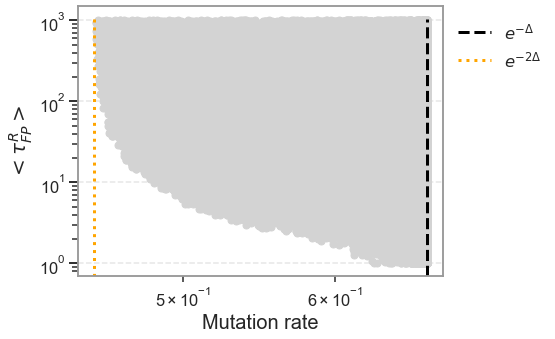

In [533]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(track_errorsp, track_fptsp, 'o', color='lightgray', markersize=7)

ylim = ax.get_ylim()
ax.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, label=r'$e^{-\Delta}$')
ax.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color = 'orange', linewidth=3, label=r'$e^{-%d\Delta}$'%(N-int(N/2)))
ax.set_xlabel('Mutation rate')
ax.set_ylabel(r'$<\tau_{FP}^R>$')

leg = plt.legend(bbox_to_anchor=(1, 1), frameon=False)

ax.set_xscale('log')
plt.yscale('log')
#plt.ylim([0, 1e4])
plt.tight_layout()
#plt.savefig('tradeoff_trajectories_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T))
plt.show()

Saving the data

In [ ]:
# with open('pareto_trajs_N_3.pickle', 'wb') as handle:
#     pickle.dump(xy_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# trajs3 = [track_errorsp, track_fptsp]
# with open('scatter_trajs_N_3.pickle', 'wb') as handle:
#     pickle.dump(trajs3, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Loading the data saved previously from running the random sampling code above

In [38]:
with open('kinetic-proofreading_data/scatter_trajs_N_3.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

x = trajs[0]
y = trajs[1]

xx_3 = np.asarray(x)
yy_3 = np.asarray(y)
xy_3 = np.concatenate([xx_3, yy_3]).reshape(2, len(xx_3)).T

Identifying the Pareto front

In [39]:
pareto_3 = identify_pareto(xy_3)

[ True  True  True ...  True  True  True]


In [40]:
idx_pareto_sorted_3 = np.argsort(xy_3[pareto_3,0])
pareto_sorted_3 = pareto_3[idx_pareto_sorted_3]

In [5]:
import pickle
# Loading saved trajectories of evolution for speed (N=3)
with open('kinetic-proofreading_data/N_3_50_trajs.pickle', 'rb') as handle:
     trajs = pickle.load(handle)

track_error_3 = trajs[2]
track_fpt_3 = trajs[4]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.plot(xy_3[pareto_sorted_3,0], xy_3[pareto_sorted_3,1], '-o', color='black', markersize=5)

fill_x3 = np.append(xy_3[pareto_sorted_3,0], np.exp(-delta))
fill_y3 = np.append(xy_3[pareto_sorted_3,1], 1e0)
plt.fill_between(fill_x3, fill_y3, \
                 y2=1e3, color='lightgray', alpha=0.3)

trace = 3
for s in range(0,10):
    if s != trace:
        ax.plot(track_error_s[s], track_fpt_s[s], '-', color=pal.wesanderson.Darjeeling2_5.mpl_colors[1], \
            linewidth=1.5, alpha=0.6, rasterized=False)  
s = trace
ax.plot(track_error_s[s], track_fpt_s[s], '-', color=pal.wesanderson.Zissou_5.mpl_colors[2], \
        linewidth=5, rasterized=False)
    
ylim = ax.get_ylim()
ax.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, label=r'$e^{-\Delta}$')
ax.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color = 'black', linewidth=3, \
        label=r'$e^{-%d\Delta}$'%(N-int(N/2)))
ax.set_xlabel('Error rate')
ax.set_ylabel(r'Time to insert a base')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([4.4e-1, 6.8e-1])
ax.set_ylim([0.8e0, 2e2])

plt.tight_layout()
#plt.savefig('tradeoff_trajectories_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'N_3_50_trajs.pickle'

## Visualize networks with kinetic constants

Let's consider for example the kinetic matrix corresponding to the last time point in the evolution; [-1]. Similarly the initial one can be accessed with [0].

In [78]:
print("Kinetic matrix values: ", N, "x", N, "\n")
print(track_k_s[0][-1])

Kinetic matrix values:  7 x 7 

[[-9.91308802e-01  7.91052488e-04  1.23971540e-04  2.47590657e-04
   4.18215757e-01  2.50447299e-08  2.02689209e-09]
 [ 5.79042375e-05 -9.97337703e-01  2.03805547e-01  5.69971090e-05
   3.60992956e-02  2.19814046e-07  2.13160839e-09]
 [ 4.60867268e-06  5.92486183e-03 -1.20255821e+00  1.00000000e+00
   4.32610019e-04  8.31302621e-04  1.98951959e-09]
 [ 1.54947885e-05  6.61691489e-05  9.98071914e-01 -1.17758868e+00
   9.88009284e-01  8.47475234e-07  3.13478038e-08]
 [ 9.91229834e-01  9.90537005e-01  2.42164892e-04  1.60668492e-03
  -1.44283908e+00  1.17232715e-07  1.98951959e-09]
 [ 9.38170370e-07  6.50745592e-06  3.11426853e-04  1.10215880e-05
   2.66206397e-06 -2.25524116e-01  2.23060522e-03]
 [ 2.27559563e-08  1.21072155e-05  3.18516124e-06  1.75666384e-01
   7.94727816e-05  2.24691604e-01 -2.23064471e-03]]


7 42


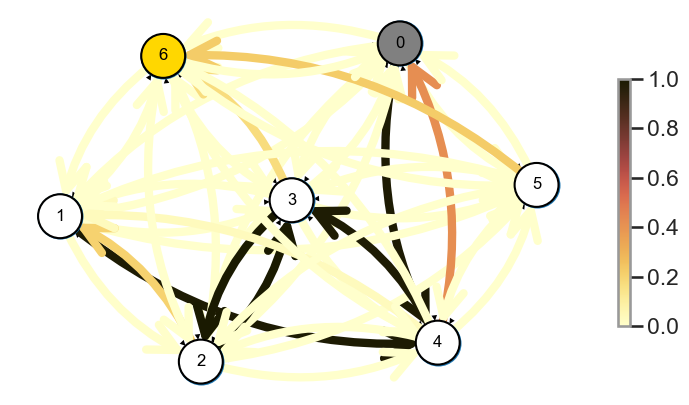

In [79]:
%autoreload 2
from plot import plot_single_network
plot_single_network(track_k_s[0][-1], N, t_stall, T)

#### Hopfield network

Defining the discrimination factor for an Hopfield network

In [23]:
delta_h = 4
np.exp(-2*delta_h)

np.float64(0.00033546262790251185)

In [24]:
N = 3
init = 0
end = N - 1
k_rH = np.zeros([1, N, N])
k_rH[0][0,1] = 1
k_rH[0][1,0] = 1
k_rH[0][2,0] = 1e-8
k_rH[0][0,2] = 1e-1
k_rH[0][1,2] = 1e-8
k_rH[0][2,1] = 1e-3
k_rH[0] = normalise_outflow(k_rH[0], N)

In [25]:
k_wH = copy.deepcopy(k_rH)
k_wH1 = np.zeros([1,N,N])

for i in range(N):
    for j in range(N):
        if i < int(N/2) and j >= int(N/2):
            k_wH[0][i,j] = k_wH[0][i,j]*np.exp(delta_h)

k_wH[0] = normalise_outflow(k_wH[0], N)
k_wH1[0] = copy.copy(k_wH[0])/max_k(copy.copy(k_rH[0]))

In [27]:
print(np.exp(-2*delta_h), error(k_rH[0], k_wH1[0], N, init, end))

0.00033546262790251185 0.00033597194970116885


3 6


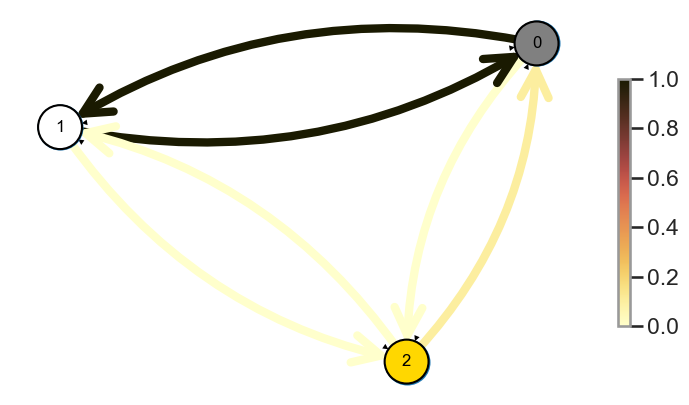

In [95]:
# %load_ext autoreload
%autoreload 2
t_stall = 0
T = 0

# If flag_mean = 1 plot full network, if = 0 plot sample=sample
flag_mean = 0
plot_single_network(k_rH[0].tolist(), N, t_stall, T)